# Steps Performed while working on given Problem Statement - 

### First we will be going with regular approach of preparing our data for our models by performing various steps like dummy encdoing, Train - Test data splitting and Initializing various models and then performing  fit() & predict() methods on our models and check their accuracies.

### From here, we will be predicting MenuItems for our already generated test data for dates 1st July,2019 to 7th July,2019 and then exporting that predicted data to an excel file which will be used again as test data for Predicting Item Quantity for each order.

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import gc

In [65]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.optimizers import SGD,Adam
from warnings import filterwarnings
filterwarnings(action='ignore')

In [63]:
data  = pd.read_excel("prepared_data.xlsx")

## General EDA - 

In [34]:
print(data.shape)
print(data.describe())
print(data.info())
print(data.MenuItem.nunique())

(22038, 7)
            ItemQty
count  22038.000000
mean       1.695707
std        0.896095
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22038 entries, 0 to 22037
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          22038 non-null  datetime64[ns]
 1   Day           22038 non-null  object        
 2   Day Type      22038 non-null  object        
 3   Shift         22038 non-null  object        
 4   MenuCategory  22038 non-null  object        
 5   MenuItem      22038 non-null  object        
 6   ItemQty       22038 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.2+ MB
None
43


In [5]:
data.head()

,Date,Day,Day Type,Shift,MenuCategory,MenuItem,ItemQty
0,2019-01-01,Tuesday,Weekday,Lunch,Starter,GOBI MANCHURIAN,1
1,2019-01-01,Tuesday,Weekday,Lunch,Starter,TASTY FLATBREAD,1
2,2019-01-01,Tuesday,Weekday,Lunch,VEGETABLE SPECIALS,SARSON DA SAAG,1
3,2019-01-01,Tuesday,Weekday,Lunch,VEGETABLE SPECIALS,PANEER VINDALOO,1
4,2019-01-01,Tuesday,Weekday,Lunch,BREADS,GARLIC NAAN,2


In [35]:
grouped_data = data.groupby(['Date','Shift','MenuItem']).agg({'ItemQty':sum})

In [36]:
grouped_data.head()

ItemQty
Date       Shift  MenuItem                     
2019-01-01 Dinner BAINGAN BARTHA              1
                  BUTTER CHICKEN              5
                  CARROT HALWA                1
                  CHICKEN TIKKA MASALA        1
                  FISH CURRY                  5

### Histogram plots from checking distribution of our data

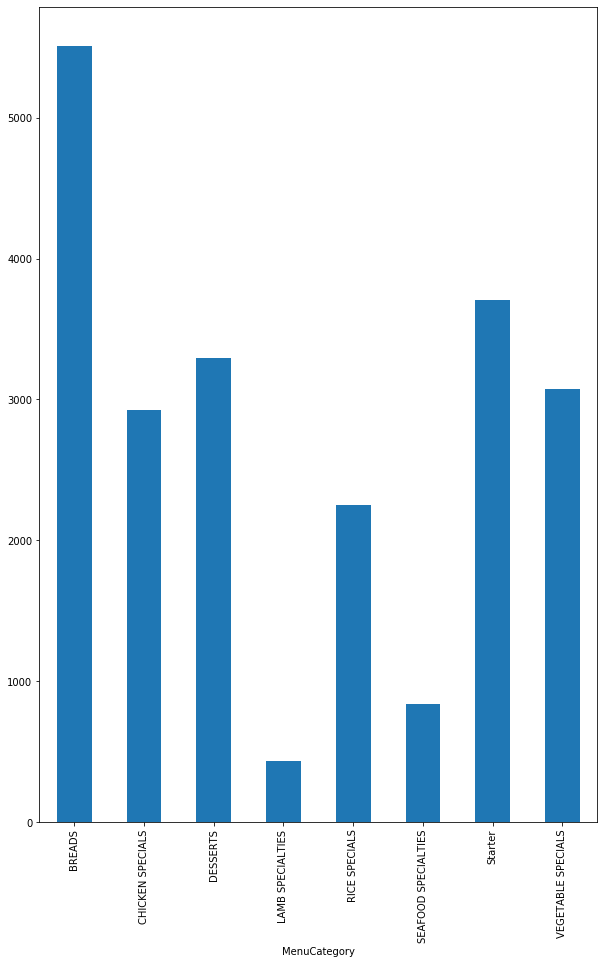

In [37]:
fig = plt.figure(figsize=(10,15))
data.groupby('MenuCategory').MenuItem.count().plot.bar(ylim=0)
plt.show()

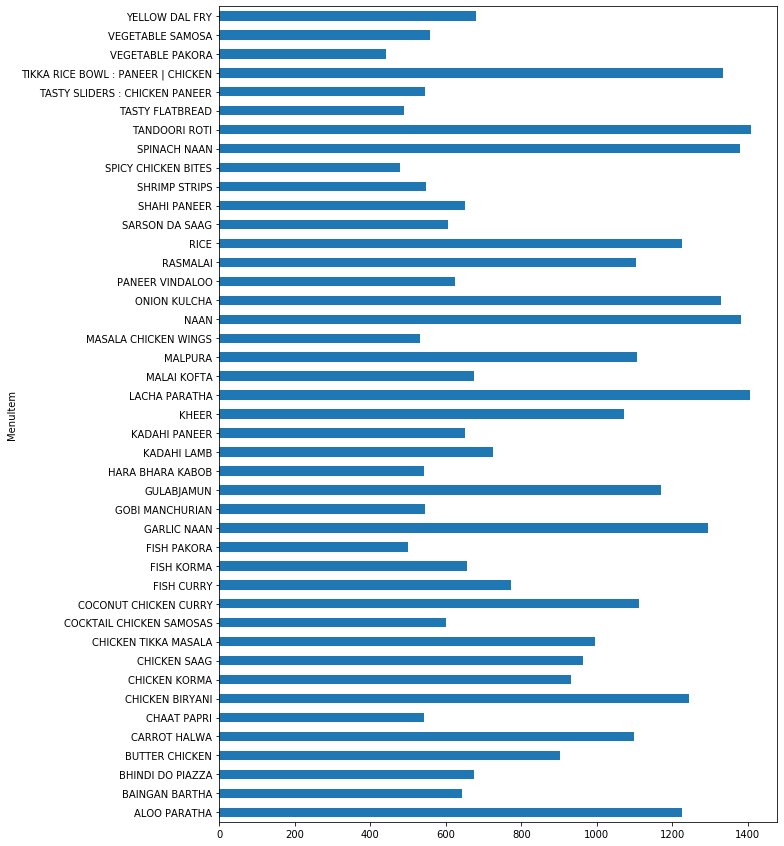

In [66]:
fig = plt.figure(figsize=(10,15))
data.groupby('MenuItem').ItemQty.sum().plot.barh(ylim=0)
plt.show()

In [6]:
prepared_data = pd.get_dummies(data=data,columns=['Shift','Day','Day Type','MenuCategory'],drop_first=True)
prepared_data = prepared_data.drop(columns=['Date','ItemQty'])
prepared_data.shape

(22038, 16)

In [7]:
prepared_data['item_id'] = prepared_data['MenuItem'].factorize()[0]
prepared_data.drop(columns=['MenuItem'],inplace=True)
prepared_data.shape

(22038, 16)

In [8]:
prepared_data.head()

,Shift_Lunch,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day Type_Weekend,MenuCategory_CHICKEN SPECIALS,MenuCategory_DESSERTS,MenuCategory_LAMB SPECIALTIES,MenuCategory_RICE SPECIALS,MenuCategory_SEAFOOD SPECIALTIES,MenuCategory_Starter,MenuCategory_VEGETABLE SPECIALS,item_id
0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4


In [ ]:
X_features = prepared_data.iloc[:,:-1].values
Y_features = prepared_data.iloc[:,-1].values

Y_features_dummy = pd.get_dummies(Y_features).values
print(X_features.shape,Y_features.shape)
Y_features_dummy[0:1]

### Note : I have also tried over sampling of data but didn't see much improvements in the results.

In [ ]:
from collections import Counter

print(Counter(Y_features))

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_features_sampled,Y_features_sampled = oversample.fit_resample(X_features,Y_features)

print(Counter(Y_features_sampled))

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_features,Y_features_dummy,test_size=0.2,random_state=42)

### We are going to create a neural network with 2 hidden layers as our classifier for predicting MenuItems

In [11]:
classifier_nn = Sequential()

classifier_nn.add(Dense(units=128,activation='relu',input_dim=15))
classifier_nn.add(Dropout(0.2))
classifier_nn.add(Dense(units=64,activation='relu'))
classifier_nn.add(Dropout(0.2))
classifier_nn.add(Dense(units=64,activation='relu'))
classifier_nn.add(Dropout(0.2))
classifier_nn.add(Dense(units=43,activation='softmax'))

sgd = SGD(lr=0.01,nesterov=True)

In [12]:
classifier_nn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
classifier_nn.fit(x_train,y_train,batch_size=128,epochs=1000)


Epoch 1/1000
17630/17630 [==============================] - 2s 96us/step - loss: 3.0242 - accuracy: 0.1172
Epoch 2/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.9897 - accuracy: 0.1983
Epoch 3/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.8976 - accuracy: 0.1969
Epoch 4/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.8636 - accuracy: 0.2001
Epoch 5/1000
17630/17630 [==============================] - 1s 35us/step - loss: 1.8440 - accuracy: 0.2026
Epoch 6/1000
17630/17630 [==============================] - 1s 35us/step - loss: 1.8327 - accuracy: 0.2001
Epoch 7/1000
17630/17630 [==============================] - 1s 37us/step - loss: 1.8221 - accuracy: 0.2008
Epoch 8/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.8205 - accuracy: 0.2019
Epoch 9/1000
17630/17630 [==============================] - 1s 36us/step - loss: 1.8161 - accuracy: 0.1986
Epoch 10/1000
17630/17630 [=========

Epoch 75/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7861 - accuracy: 0.2136
Epoch 76/1000
17630/17630 [==============================] - 1s 35us/step - loss: 1.7861 - accuracy: 0.2120
Epoch 77/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.7849 - accuracy: 0.2148
Epoch 78/1000
17630/17630 [==============================] - 1s 37us/step - loss: 1.7850 - accuracy: 0.2178
Epoch 79/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7856 - accuracy: 0.2111
Epoch 80/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7854 - accuracy: 0.2140
Epoch 81/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7863 - accuracy: 0.2091
Epoch 82/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7856 - accuracy: 0.2096
Epoch 83/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7850 - accuracy: 0.2099
Epoch 84/1000
17630/17630 [=

17630/17630 [==============================] - 1s 34us/step - loss: 1.7827 - accuracy: 0.2212
Epoch 151/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7830 - accuracy: 0.2185
Epoch 152/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7823 - accuracy: 0.2175
Epoch 153/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7822 - accuracy: 0.2188
Epoch 154/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7829 - accuracy: 0.2206
Epoch 155/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7819 - accuracy: 0.2201
Epoch 156/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7819 - accuracy: 0.2184
Epoch 157/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7827 - accuracy: 0.2207
Epoch 158/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7829 - accuracy: 0.2222
Epoch 159/1000
17630/17630 [======

17630/17630 [==============================] - 1s 33us/step - loss: 1.7804 - accuracy: 0.2233
Epoch 225/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7816 - accuracy: 0.2201
Epoch 226/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.7809 - accuracy: 0.2188
Epoch 227/1000
17630/17630 [==============================] - 1s 39us/step - loss: 1.7807 - accuracy: 0.2217
Epoch 228/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7811 - accuracy: 0.2237
Epoch 229/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7818 - accuracy: 0.2206
Epoch 230/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7799 - accuracy: 0.2234
Epoch 231/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7816 - accuracy: 0.2187
Epoch 232/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7803 - accuracy: 0.2222
Epoch 233/1000
17630/17630 [======

17630/17630 [==============================] - 1s 37us/step - loss: 1.7801 - accuracy: 0.2208
Epoch 300/1000
17630/17630 [==============================] - 1s 35us/step - loss: 1.7794 - accuracy: 0.2208
Epoch 301/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7792 - accuracy: 0.2235
Epoch 302/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7805 - accuracy: 0.2250
Epoch 303/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7795 - accuracy: 0.2228
Epoch 304/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7796 - accuracy: 0.2185
Epoch 305/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7794 - accuracy: 0.2239
Epoch 306/1000
17630/17630 [==============================] - 1s 34us/step - loss: 1.7795 - accuracy: 0.2221
Epoch 307/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7798 - accuracy: 0.2196
Epoch 308/1000
17630/17630 [======

17630/17630 [==============================] - 1s 34us/step - loss: 1.7799 - accuracy: 0.2201
Epoch 375/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7800 - accuracy: 0.2275
Epoch 376/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7804 - accuracy: 0.2218
Epoch 377/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7792 - accuracy: 0.2221
Epoch 378/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7791 - accuracy: 0.2233
Epoch 379/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7788 - accuracy: 0.2240
Epoch 380/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7792 - accuracy: 0.2232
Epoch 381/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7788 - accuracy: 0.2233
Epoch 382/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7800 - accuracy: 0.2255
Epoch 383/1000
17630/17630 [======

17630/17630 [==============================] - 1s 32us/step - loss: 1.7789 - accuracy: 0.2245
Epoch 450/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7794 - accuracy: 0.2224
Epoch 451/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7786 - accuracy: 0.2238
Epoch 452/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7783 - accuracy: 0.2216
Epoch 453/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7798 - accuracy: 0.2246
Epoch 454/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7794 - accuracy: 0.2226
Epoch 455/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7789 - accuracy: 0.2231
Epoch 456/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7787 - accuracy: 0.2240
Epoch 457/1000
17630/17630 [==============================] - 1s 37us/step - loss: 1.7793 - accuracy: 0.2207
Epoch 458/1000
17630/17630 [======

17630/17630 [==============================] - 1s 33us/step - loss: 1.7781 - accuracy: 0.2237
Epoch 524/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7781 - accuracy: 0.2258
Epoch 525/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7782 - accuracy: 0.2215
Epoch 526/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7782 - accuracy: 0.2290
Epoch 527/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7784 - accuracy: 0.2280
Epoch 528/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7797 - accuracy: 0.2244
Epoch 529/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7780 - accuracy: 0.2298
Epoch 530/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7775 - accuracy: 0.2286
Epoch 531/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7788 - accuracy: 0.2244
Epoch 532/1000
17630/17630 [======

17630/17630 [==============================] - 1s 32us/step - loss: 1.7784 - accuracy: 0.2239
Epoch 599/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7790 - accuracy: 0.2236
Epoch 600/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7789 - accuracy: 0.2216
Epoch 601/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7787 - accuracy: 0.2251
Epoch 602/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7786 - accuracy: 0.2231
Epoch 603/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7780 - accuracy: 0.2260
Epoch 604/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7781 - accuracy: 0.2254
Epoch 605/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7790 - accuracy: 0.2265
Epoch 606/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7779 - accuracy: 0.2258
Epoch 607/1000
17630/17630 [======

17630/17630 [==============================] - 1s 33us/step - loss: 1.7789 - accuracy: 0.2186
Epoch 674/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7785 - accuracy: 0.2227
Epoch 675/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7778 - accuracy: 0.2283
Epoch 676/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7782 - accuracy: 0.2231
Epoch 677/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7789 - accuracy: 0.2269
Epoch 678/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7785 - accuracy: 0.2252
Epoch 679/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7791 - accuracy: 0.2269
Epoch 680/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7785 - accuracy: 0.2240
Epoch 681/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7789 - accuracy: 0.2243
Epoch 682/1000
17630/17630 [======

17630/17630 [==============================] - 1s 33us/step - loss: 1.7784 - accuracy: 0.2284
Epoch 748/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7777 - accuracy: 0.2239
Epoch 749/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7781 - accuracy: 0.2238
Epoch 750/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7773 - accuracy: 0.2256
Epoch 751/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7786 - accuracy: 0.2245
Epoch 752/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7772 - accuracy: 0.2260
Epoch 753/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7772 - accuracy: 0.2294
Epoch 754/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7780 - accuracy: 0.2262
Epoch 755/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7779 - accuracy: 0.2254
Epoch 756/1000
17630/17630 [======

17630/17630 [==============================] - 1s 33us/step - loss: 1.7783 - accuracy: 0.2296
Epoch 823/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7771 - accuracy: 0.2252
Epoch 824/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7785 - accuracy: 0.2255
Epoch 825/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7784 - accuracy: 0.2265
Epoch 826/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7775 - accuracy: 0.2243
Epoch 827/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7778 - accuracy: 0.2255
Epoch 828/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7780 - accuracy: 0.2252
Epoch 829/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7781 - accuracy: 0.2257
Epoch 830/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7784 - accuracy: 0.2243
Epoch 831/1000
17630/17630 [======

17630/17630 [==============================] - 1s 34us/step - loss: 1.7772 - accuracy: 0.2276
Epoch 898/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7787 - accuracy: 0.2248
Epoch 899/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7781 - accuracy: 0.2234
Epoch 900/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7773 - accuracy: 0.2277
Epoch 901/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7770 - accuracy: 0.2289
Epoch 902/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7784 - accuracy: 0.2285
Epoch 903/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7777 - accuracy: 0.2289
Epoch 904/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7785 - accuracy: 0.2239
Epoch 905/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7778 - accuracy: 0.2243
Epoch 906/1000
17630/17630 [======

17630/17630 [==============================] - 1s 32us/step - loss: 1.7770 - accuracy: 0.2258
Epoch 973/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7784 - accuracy: 0.2270
Epoch 974/1000
17630/17630 [==============================] - 1s 33us/step - loss: 1.7769 - accuracy: 0.2274
Epoch 975/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7774 - accuracy: 0.2273
Epoch 976/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7768 - accuracy: 0.2288
Epoch 977/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7773 - accuracy: 0.2260
Epoch 978/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7778 - accuracy: 0.2286
Epoch 979/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7776 - accuracy: 0.2254
Epoch 980/1000
17630/17630 [==============================] - 1s 32us/step - loss: 1.7788 - accuracy: 0.2228
Epoch 981/1000
17630/17630 [======

In [14]:
score = classifier_nn.evaluate(x_test,y_test,batch_size=128)
score

4408/4408 [==============================] - 0s 42us/step


[1.8083463349056763, 0.18421052396297455]

In [21]:
y_pred = classifier_nn.predict_classes(x_test)
rounded_predictions = y_pred
rounded_predictions[1]

33

In [22]:
from sklearn import metrics

import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

10

In [24]:
cm = metrics.confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[19,  0,  0, ...,  0,  0,  0],
       [20,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 13, ...,  0,  0,  0],
       ...,
       [24,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, 33,  0],
       [ 0,  0,  0, ...,  0,  0, 30]], dtype=int64)

In [25]:
print(metrics.accuracy_score(rounded_labels, rounded_predictions))

0.18421052631578946


In [27]:
gc.collect()

6049

### Next we will be using PyCaret library which is an open source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights.

#### Creating a model in any module is as simple as writing create_model. It takes only one parameter i.e. the model abbreviation as string. For supervised modules (classification and regression) this function returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object.The evaluation metrics used are:

#### Classification: Accuracy, AUC, Recall, Precision, F1, Kappa


## Advantages of PyCaret :
        Performs all data preprocessing steps by itself like handling missing values,handling categoricals,sampling of data,
        splitting of training and test data,10 fold cross validation or even hyperparameter tuning, PyCaret automates 
        all of it.

In [28]:
from pycaret.classification import *

In [29]:
''' Data preparation step in pycaret '''
data_pycaret_model = data.drop(columns=['Date','ItemQty'])
clf1 = setup(data = data_pycaret_model, target = 'MenuItem')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2021
1,Target Type,Multiclass
2,Label Encoded,"ALOO PARATHA: 0, BAINGAN BARTHA: 1, BHINDI DO PIAZZA: 2, BUTTER CHICKEN: 3, CARROT HALWA: 4, CHAAT PAPRI: 5, CHICKEN BIRYANI: 6, CHICKEN KORMA: 7, CHICKEN SAAG: 8, CHICKEN TIKKA MASALA: 9, COCKTAIL CHICKEN SAMOSAS: 10, COCONUT CHICKEN CURRY: 11, FISH CURRY: 12, FISH KORMA: 13, FISH PAKORA: 14, GARLIC NAAN: 15, GOBI MANCHURIAN: 16, GULABJAMUN: 17, HARA BHARA KABOB: 18, KADAHI LAMB: 19, KADAHI PANEER: 20, KHEER: 21, LACHA PARATHA: 22, MALAI KOFTA: 23, MALPURA: 24, MASALA CHICKEN WINGS: 25, NAAN: 26, ONION KULCHA: 27, PANEER VINDALOO: 28, RASMALAI: 29, RICE: 30, SARSON DA SAAG: 31, SHAHI PANEER: 32, SHRIMP STRIPS: 33, SPICY CHICKEN BITES: 34, SPINACH NAAN: 35, TANDOORI ROTI: 36, TASTY FLATBREAD: 37, TASTY SLIDERS : CHICKEN PANEER: 38, TIKKA RICE BOWL : PANEER | CHICKEN: 39, VEGETABLE PAKORA: 40, VEGETABLE SAMOSA: 41, YELLOW DAL FRY: 42"
3,Original Data,"(22038, 5)"
4,Missing Values,False
5,Numeric Features,0
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [30]:
''' Creating XGBOOST classifier model for predicting MenuItems with 10 fold Cross validation '''
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.2119,0.0,0.1930,0.1954,0.1951,0.1902
1,0.2087,0.0,0.1906,0.2018,0.1888,0.1869
2,0.1931,0.0,0.1775,0.1848,0.1807,0.1709
3,0.1905,0.0,0.1745,0.1716,0.1713,0.1683
4,0.2165,0.0,0.2009,0.1965,0.1948,0.1949
5,0.2054,0.0,0.1953,0.1850,0.1832,0.1836
6,0.1997,0.0,0.1878,0.1869,0.1830,0.1777
7,0.2224,0.0,0.2100,0.2080,0.2017,0.2010
8,0.1868,0.0,0.1760,0.1753,0.1688,0.1644
9,0.2069,0.0,0.1914,0.1927,0.1898,0.1850


In [31]:
''' Creating RandomForest Classifier model for predicting MenuItems with 10 fold Cross validation '''
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.2003,0.0,0.1814,0.1887,0.1851,0.1783
1,0.2035,0.0,0.1872,0.1872,0.1837,0.1815
2,0.1892,0.0,0.1739,0.1800,0.1767,0.1669
3,0.1938,0.0,0.1789,0.1743,0.1760,0.1717
4,0.1977,0.0,0.1833,0.1803,0.1804,0.1757
5,0.1977,0.0,0.1864,0.1772,0.1785,0.1757
6,0.1842,0.0,0.1702,0.1758,0.1683,0.1617
7,0.2069,0.0,0.1958,0.1860,0.1892,0.1852
8,0.1991,0.0,0.1848,0.1888,0.1833,0.1771
9,0.1920,0.0,0.1801,0.1853,0.1816,0.1698


In [32]:
''' Tuning RandomForest Model to get better results using Pycaret '''
rf_tuned = tune_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.2080,0.0,0.1898,0.1866,0.1887,0.1862
1,0.2087,0.0,0.1898,0.1967,0.1905,0.1868
2,0.1866,0.0,0.1717,0.1813,0.1762,0.1643
3,0.1905,0.0,0.1723,0.1791,0.1759,0.1684
4,0.2061,0.0,0.1895,0.1935,0.1872,0.1842
5,0.1938,0.0,0.1833,0.1724,0.1733,0.1716
6,0.1907,0.0,0.1757,0.1744,0.1725,0.1684
7,0.2173,0.0,0.2058,0.1995,0.1962,0.1957
8,0.2043,0.0,0.1892,0.1905,0.1859,0.1823
9,0.1933,0.0,0.1758,0.1775,0.1749,0.1710


In [33]:
''' Creating Gradient Boosting Classifier model for predicting MenuItems with 10 fold Cross validation '''
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.2145,0.0,0.1971,0.1970,0.1967,0.1928
1,0.2041,0.0,0.1861,0.1915,0.1858,0.1822
2,0.1879,0.0,0.1742,0.1780,0.1753,0.1656
3,0.1938,0.0,0.1770,0.1810,0.1780,0.1717
4,0.2106,0.0,0.1949,0.1964,0.1907,0.1889
5,0.2029,0.0,0.1927,0.1915,0.1843,0.1810
6,0.1952,0.0,0.1811,0.1787,0.1774,0.1731
7,0.2166,0.0,0.2056,0.2014,0.1962,0.1951
8,0.2004,0.0,0.1866,0.1868,0.1809,0.1783
9,0.1958,0.0,0.1815,0.1823,0.1790,0.1737


### As we can examine from outputs of various classification models, overall performance of XGBOOST is higher than others.

### So we will be using XGBOOST model as our final model for predictions of MenuItems on test set.

In [53]:
''' Importing Test set created for dates from 1st July,2019 to 7th July,2019 '''
load_test_data = pd.read_excel('test_data.xlsx')
test_data = load_test_data.copy()
test_data.drop(columns=['Date','ItemQty','MenuItem'],inplace=True)
test_data.head(10)

,Day,Day Type,Shift,MenuCategory
0,Monday,Weekday,Lunch,DESSERTS
1,Monday,Weekday,Lunch,BREADS
2,Monday,Weekday,Lunch,BREADS
3,Monday,Weekday,Lunch,VEGETABLE SPECIALS
4,Monday,Weekday,Lunch,CHICKEN SPECIALS
5,Monday,Weekday,Lunch,SEAFOOD SPECIALTIES
6,Monday,Weekday,Lunch,VEGETABLE SPECIALS
7,Monday,Weekday,Lunch,BREADS
8,Monday,Weekday,Lunch,Starter
9,Monday,Weekday,Lunch,BREADS


In [59]:
model_predictions = predict_model(xgboost,test_data)
model_predictions

,Day,Day Type,Shift,MenuCategory,Label,Score
0,Monday,Weekday,Lunch,DESSERTS,17,0.2180
1,Monday,Weekday,Lunch,BREADS,36,0.1796
2,Monday,Weekday,Lunch,BREADS,36,0.1796
3,Monday,Weekday,Lunch,VEGETABLE SPECIALS,32,0.1836
4,Monday,Weekday,Lunch,CHICKEN SPECIALS,9,0.2412
...,...,...,...,...,...,...
841,Sunday,Weekend,Dinner,CHICKEN SPECIALS,11,0.2304
842,Sunday,Weekend,Dinner,VEGETABLE SPECIALS,2,0.1525
843,Sunday,Weekend,Dinner,DESSERTS,29,0.2562
844,Sunday,Weekend,Dinner,BREADS,22,0.1708


In [57]:
mapping_of_items = { 0:'ALOO PARATHA',  1:'BAINGAN BARTHA',  2:'BHINDI DO PIAZZA',  3:'BUTTER CHICKEN',  4:'CARROT HALWA', 
                     5:'CHAAT PAPRI',  6:'CHICKEN BIRYANI',  7:'CHICKEN KORMA',  8:'CHICKEN SAAG', 9:'CHICKEN TIKKA MASALA' ,
                     10:'COCKTAIL CHICKEN SAMOSAS',  11:'COCONUT CHICKEN CURRY',  12:'FISH CURRY',  13:'FISH KORMA',  14:'FISH PAKORA',
                     15:'GARLIC NAAN',  16:'GOBI MANCHURIAN',  17:'GULABJAMUN',  18:'HARA BHARA KABOB',  19:'KADAHI LAMB',
                     20:'KADAHI PANEER',  21:'KHEER',  22:'LACHA PARATHA',  23:'MALAI KOFTA',  24:'MALPURA',  25:'MASALA CHICKEN WINGS',
                    26:'NAAN' , 27:'ONION KULCHA' , 28:'PANEER VINDALOO' , 29:'RASMALAI' , 30:'RICE' ,  31:'SARSON DA SAAG', 
                     32:'SHAHI PANEER',  33:'SHRIMP STRIPS',  34:'SPICY CHICKEN BITES',  35:'SPINACH NAAN',  36:'TANDOORI ROTI',
                    37:'TASTY FLATBREAD' ,  38:'TASTY SLIDERS : CHICKEN PANEER', 39:'TIKKA RICE BOWL : PANEER | CHICKEN' ,
                     40:'VEGETABLE PAKORA', 41:'VEGETABLE SAMOSA' ,  42:'YELLOW DAL FRY'}

In [60]:
''' Converting the labels into names of food items using above mapping '''
model_predictions['MenuItem'] = model_predictions.Label.apply(lambda x: mapping_of_items.get(x))
model_predictions['Date'] = load_test_data.Date.apply(lambda x: x)
model_predictions.drop(columns=['Label','Score'],inplace=True)
model_predictions = model_predictions[['Date', 'Day', 'Day Type', 'Shift', 'MenuCategory', 'MenuItem']]
model_predictions.head()

,Date,Day,Day Type,Shift,MenuCategory,MenuItem
0,2019-07-01,Monday,Weekday,Lunch,DESSERTS,GULABJAMUN
1,2019-07-01,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI
2,2019-07-01,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI
3,2019-07-01,Monday,Weekday,Lunch,VEGETABLE SPECIALS,SHAHI PANEER
4,2019-07-01,Monday,Weekday,Lunch,CHICKEN SPECIALS,CHICKEN TIKKA MASALA


In [64]:
''' Exporting results to an excel file which will be used as test data for predicting Item Quantity for each MenuItem '''
model_predictions.to_excel('Predicted_MenuItems.xlsx',index=False)

In [62]:
gc.collect()

53467